In [1]:
import warnings
warnings.filterwarnings('ignore')

# Forward Modeling for self-demagnetization and remanence

In [2]:

import simpeg.potential_fields.magnetics as mag
from simpeg import utils,maps
import numpy as np
import matplotlib.pyplot as plt

## Background

The magnetic field $\mathbf{B}$ is linear function of magnetization $\mathbf{M}$

$\mathbf{M}$ is a function of the susceptibility $\chi= \frac{\mu}{\mu_0} -1$ and remanent magnetization $\mathbf{M}_r$:

$$
\mathbf{M}=\chi(\mathbf{H_0}+\mathbf{H_s})+\mathbf{M}_r
$$

where $\mathbf{H_0}$ is the primary (background) geomagnetic field and $\mathbf{H_s}$ is the secondary field

Standard integral codes assume $\mathbf{H_s}$ is negligible compared to $\mathbf{H_0}$, so:
$$
\mathbf{M}\approx\chi\mathbf{H_0}+\mathbf{M}_r
$$




## Differential Equation Approach

To efficiently handle self-demagnetization and remanence, we can use Maxwell's equations in differential form:

$$
\nabla \cdot \mathbf{B} = 0, \quad \mathbf{B} = \mu_0 (\mathbf{H} + \mathbf{M}), \quad \mathbf{H} = -\nabla \phi
$$

using the full relation:

$$
\mathbf{M}=\chi(\mathbf{H_0}+\mathbf{H_s})+\mathbf{M}_r
$$

After some algebra, we get the boundary value problem:

$$
\nabla\cdot\mu\nabla\phi=\nabla\cdot\mu_0\mathbf{M}_r
$$

Where we enforce the boundary condition:

$$
\mathbf{B} \to \mathbf{B}_0 \quad \text{as} \quad |\mathbf{r}| \to \infty
$$






## Key points

Unlike traditional integral formulations, the differential approach represents field variables everywhere in space.
Therefore:

1. **Field variables are continuous across the entire domain**
   → We can compute and visualize $\mathbf{B}$, $\mu_0\mathbf{H}$, and $\mu_0\mathbf{M}$ anywhere on the mesh.

2. **We refine where we measure or care about the fields**
   → For example, we can increase mesh resolution near receivers.
   *(In integral codes, these points might not even lie inside mesh.)*

3. **We must expand the mesh to enforce boundary conditions**
   → The computational domain should extend far enough that
   $\mathbf{B} \to \mathbf{B}_0$ at the outer boundary.

# SimPEG Simulation

To create the simulation class with SimPEG we provide:

1. **A survey**
   → Contains receiver points, measured components, and ambient field information

2. **The mesh**
   → Here we use an Octree to efficiently satisfy boundary conditions

3. **Mappings**
   → Take our forward modeling model (a 1d vector) and populate physical properties throughout the mesh

Once we have these, we can compute the **data** or **fields** for any model


# Defining a survey

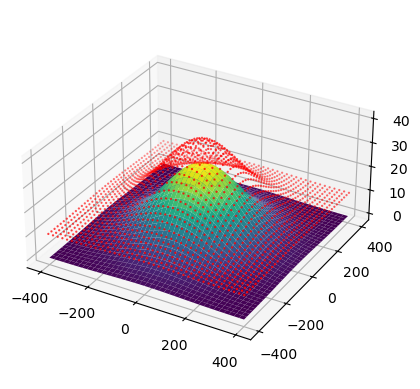

In [3]:
[xx, yy] = np.meshgrid(np.linspace(-400, 400, 41), np.linspace(-400, 400, 41))
b = 150
A = 30
z_topo = A * np.exp(-0.5 * ((xx / b) ** 2.0 + (yy / b) ** 2.0))
topo = np.c_[utils.mkvc(xx), utils.mkvc(yy), utils.mkvc(z_topo)]

z_rx = z_topo+10

rx_points = np.c_[utils.mkvc(xx), utils.mkvc(yy), utils.mkvc(z_rx)]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, .5])
ax.scatter(xx,yy,z_rx, c='r',s=.4)
ax.plot_surface(xx, yy, z_topo, cmap='viridis')


In [4]:
# Define our simpeg survey

#Define our reciever class, here TMI data only
receivers = mag.receivers.Point(rx_points,components='tmi')

#Define our source field
amplitude, inclination, declination = 50000.0, 90.0, 0.0

source_field = mag.sources.UniformBackgroundField(receiver_list=receivers, amplitude=amplitude, inclination=inclination, declination=declination)

#Define our survey
survey = mag.survey.Survey(source_field)


# Defining the mesh

We define the mesh based on our region of interest.

In [5]:
import discretize
from discretize.utils import refine_tree_xyz
pad = 20*800
cell_size_x = 10
cell_size_y = 10
cell_size_z = 7.5

#Ensure number of base cells in binary
nbc_x= int(2**np.rint(np.log2(pad/cell_size_x)))
nbc_y= int(2**np.rint(np.log2(pad/cell_size_y)))
nbc_z= int(2**np.rint(np.log2(pad/cell_size_z)))


hx = cell_size_x*np.ones(nbc_x)
hy = cell_size_y*np.ones(nbc_y)
hz = cell_size_z*np.ones(nbc_z)

mesh = discretize.TreeMesh(h=[hx, hy, hz], origin="CCC")
mx_level=mesh.max_level

mesh.refine_box(x0s=(-500, -500, -220), x1s=(500, 500, 30), levels=mx_level-1, finalize=False, diagonal_balance=True)
mesh.refine_box(x0s=(-700, -700, -380), x1s=(700, 700, 70), levels=mx_level-2, finalize=False, diagonal_balance=True)
mesh.refine_box(x0s=(-1000, -1000, -650), x1s=(1000, 1000, 80), levels=mx_level-3, finalize=False, diagonal_balance=True)
mesh.refine_surface(xyz=rx_points,level=-1,padding_cells_by_level=[8,0])
#mesh.refine_surface(xyz=topo,level=-1,padding_cells_by_level=1)

# mesh = refine_tree_xyz(
#     mesh, rx_points, method="surface", octree_levels=[5], finalize=False
# )
mesh.finalize()
#mesh.maxLevel


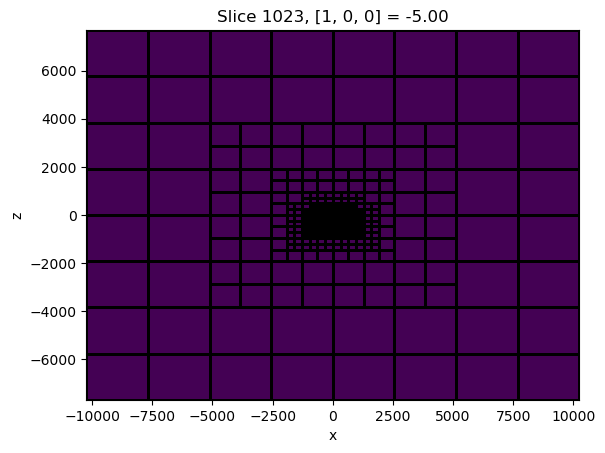

The mesh has 172012 cells


In [6]:

mesh.plot_slice(np.zeros(mesh.n_cells),normal="x",slice_loc=0,grid=True)
plt.gca().set_aspect("equal")
plt.show()
print('The mesh has '+ str(mesh.n_cells) +' cells')

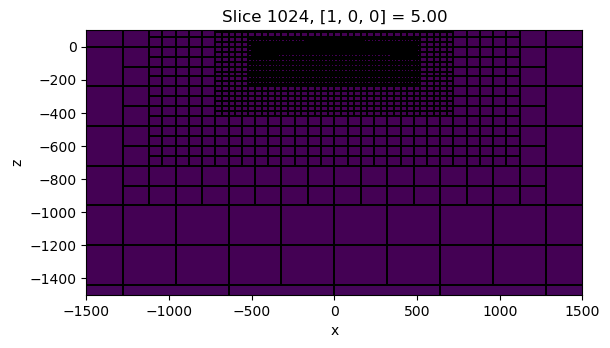

In [7]:
grid_opts = {"linewidth": 0.005, "color": "k"}

mesh.plot_slice(mesh.cell_volumes, normal="x", grid=True, grid_opts=grid_opts)
plt.gca().set_aspect("equal")
plt.xlim(-1.5e3, 1.5e3)
plt.ylim(-1.5e3, 100)
plt.show()

Now we define active region where we want to invert. We do this by octree level and using topography

In [8]:
ind_active_topo = discretize.utils.active_from_xyz(mesh, topo)

#Small
max_active_level=-4
cl = mesh.cell_levels_by_index(np.arange(mesh.n_cells))

cond = (cl == mx_level)
for i in range(np.abs(max_active_level)-1):  
    cond=cond+(cl == mx_level - (i+1))

active_cells = cond*ind_active_topo

n_active = np.sum(active_cells)

#array of booleans indicating active parameters
print(active_cells)

[False False False ... False False False]


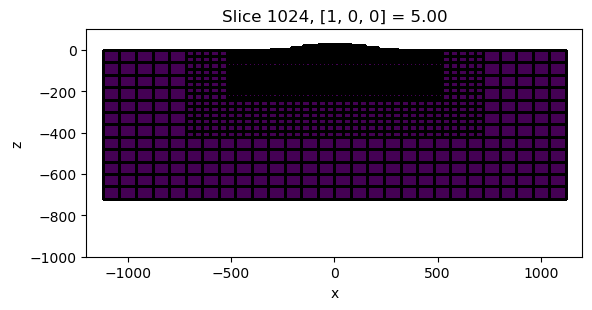

The mesh has 131151 active cells


In [9]:
plotting_model = np.zeros(mesh.n_cells)

#Use nan to not plot inactive cells
plotting_model[~active_cells] = np.nan

mesh.plot_slice(plotting_model, normal="x", grid=True, )#grid_opts=grid_opts)
plt.gca().set_aspect("equal")
plt.xlim(-1.2e3, 1.2e3)
plt.ylim(-1.0e3, 100)
plt.show()

print('The mesh has '+ str(n_active) +' active cells')

# Mappings

Next we can define **mappings**.

These take our **model**, however it is defined, and provide the simulation with **physical properties**.

While SimPEG doesn't require physical property models at this stage, we create them first to show how mappings work

Unlike models used for plotting, physical property models are defined only at **active** cells

In [10]:
#Define a geologic model using a rectangular prism

#center coordinates
x0,y0,z0 = 0,0,-180

#widths
hx,hy,hz = 200,200,50

#angles with respect to coordinate axes
phi_x,phi_y,phi_z = -45, 0, 0
from notebooks.Utils.aqgeo_utils import get_ind_prism
ind_prism = get_ind_prism(hx,hy,hz,phi_x,phi_y,phi_z,x0,y0,z0,mesh.cell_centers[active_cells,:])

geo_model = np.zeros(n_active)

geo_model[ind_prism] = 1

print(geo_model.shape)

(131151,)


To plot the model, it must have the same dimensionality as the total .

We use a **mapping** to achieve this.

In SimPEG, * applies the mapping function $\mathbf{f_{map}}$ on model vector $\mathbf{m}$:

$map*m \stackrel{\mathrm{def}}{=} \mathbf{f_{map}(m)}$

We use the mapping InjectActiveCells to assign inactive cells a dummy value (nan), which SimPEG treats as transparent during plotting.

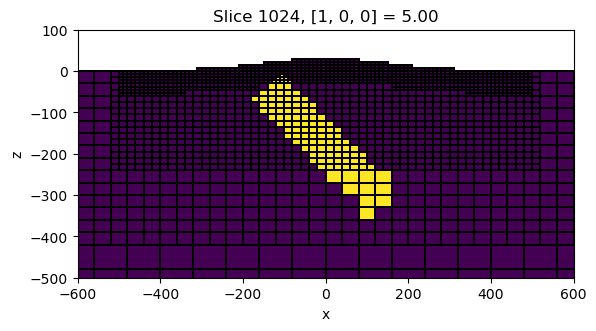

(172012,)


In [11]:
#Create the map
plot_map = maps.InjectActiveCells(mesh, active_cells,np.nan)

#Apply to geo model
plot_model = plot_map*geo_model


mesh.plot_slice(plot_model, normal="x", grid=False, grid_opts=grid_opts,)
plt.gca().set_aspect("equal")
plt.xlim(-600, 600)
plt.ylim(-500, 100)
plt.show()


print(plot_model.shape)

Next we define our physical properties throughout the active mesh

We define our remanent magnetization $m_r$ in terms of normalized components:

$m_{rx}=\mathbf{M_{rx}}/|\mathbf{H_0}|$

This gives same units and order of magnitude as $m_\chi$

Here the values of the block are $\chi=5$ SI, $\vec{M}_{r}/|\mathbf{H_0}| = (3,-3,0)$ SI

In [12]:
m_chi = np.zeros(n_active)
m_chi[ind_prism] = 5
m_rx = np.zeros(n_active)
m_rx[ind_prism] = 3
m_ry = np.zeros(n_active)
m_ry[ind_prism] = -3
m_rz = np.zeros(n_active)
m_rz[ind_prism] = 0

model = np.r_[m_chi, m_rx, m_ry, m_rz]
print(model.shape)



(524604,)


It is convenient to store everything as a 1d vector for inversion.

However, our simulation class needs to know what part of the model is located where. To do this we use a **wire map**.

We can compose maps through the * operation:

$map_2*map_1*m = \mathbf{f_{map_2}(f_{map_1}(m))}$

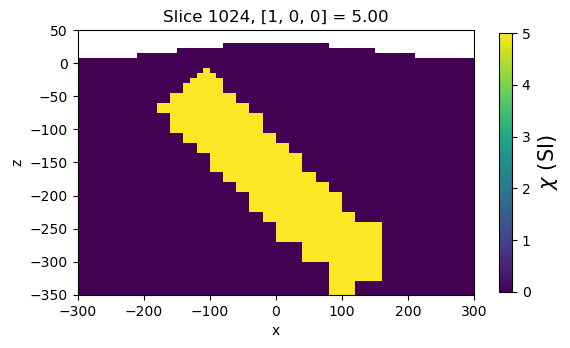

In [13]:
#Name of wire, followed by how many parameters, in the correct order
wire_map = maps.Wires(("m_chi", n_active), ("m_r", n_active*3))

#wire_map.m_chi picks out the susceptibility
chi_plot = plot_map*wire_map.m_chi*model

im=mesh.plot_slice(chi_plot, normal="x", grid=False)
plt.gca().set_aspect("equal")
cbar=plt.colorbar(im[0],shrink=.7)
cbar.set_label(r'$\chi$ (SI)',rotation=90,size=15)
plt.xlim(-300, 300)
plt.ylim(-350, 50)
plt.show()

To plot the vector, the remanence needs to be reshaped...

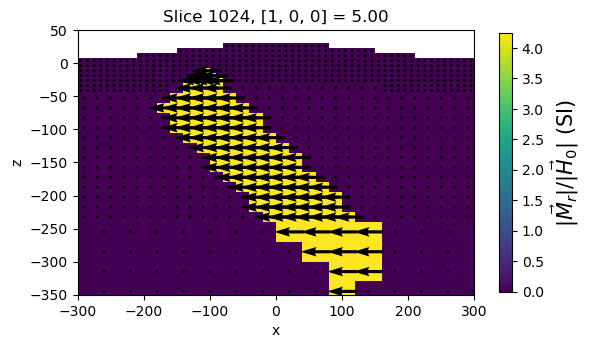

In [14]:
mr_plot = plot_map*(wire_map.m_r*model).reshape((n_active,3),order='F')


im=mesh.plot_slice(mr_plot, normal="x", grid=False,view="vec",v_type="CCv",quiver_opts={
                "pivot": "mid",
                "scale": 10,
                "width":.008,
                "scale_units": "inches",
            },)

plt.gca().set_aspect("equal")
cbar=plt.colorbar(im[0][0],shrink=.7)
cbar.set_label(r'$|\vec{M}_r|/|\vec{H}_0|$ (SI)',rotation=90,size=15)
plt.xlim(-300, 300)
plt.ylim(-350, 50)
plt.show()


Our simulation is based on the differential equation:

$$
\nabla\cdot\mu\nabla\phi=\nabla\cdot\mu_0\mathbf{M}_r
$$

So physical properties are parameterized in terms of $\mu$ (H/m) and $\mu_0 M_r$ (n_T).

We use **ChiMap** to convert $\chi$ to $\mu$ and **EffectiveSusceptibilityMap** to convert $\frac{\mu_0M_r}{|B_0|}$ to ${\mu_0M_r}$

Once again, these quantities are required throughout the mesh for the differential method

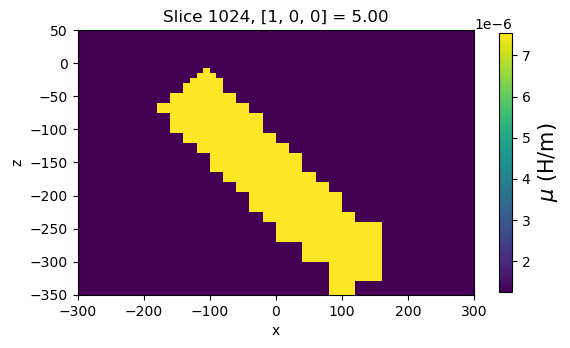

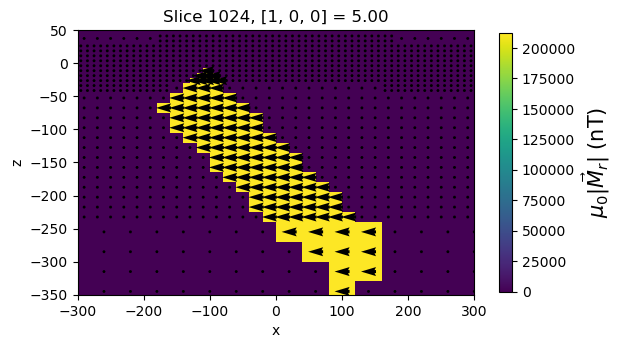

In [15]:
from scipy.constants import mu_0

#Create map to inject inactive cells with mu_0
mu_0_injection = maps.InjectActiveCells(mesh, active_cells, mu_0 )
chi_map = maps.ChiMap(nP=n_active)

#create map to inject 0 for mu_0M_r
rem_injection = maps.InjectActiveCells(mesh, np.hstack((active_cells, active_cells, active_cells)), 0,nC=mesh.n_cells*3 )
EffectiveSusceptibilityMap = maps.EffectiveSusceptibilityMap(nP = n_active*3, ambient_field_magnitude = survey.source_field.amplitude)

#Create the total maps for our simulatoin
mu_map = mu_0_injection*chi_map*wire_map.m_chi
rem_map = rem_injection*EffectiveSusceptibilityMap*wire_map.m_r


im=mesh.plot_slice(mu_map*model, normal="x", grid=False)
plt.gca().set_aspect("equal")
cbar=plt.colorbar(im[0],shrink=.7)
cbar.set_label(r'$\mu$ (H/m)',rotation=90,size=15)
plt.xlim(-300, 300)
plt.ylim(-350, 50)
plt.show()

im=mesh.plot_slice((rem_map*model).reshape((-1,3),order='F'), normal="x", grid=False,view="vec",v_type="CCv",quiver_opts={
                "pivot": "mid",
                "scale": 1000000,
                "width":.008,
                "scale_units": "inches",
            },)

plt.gca().set_aspect("equal")
cbar=plt.colorbar(im[0][0],shrink=.7)
cbar.set_label(r'$\mu_0|\vec{M}_r|$ (nT)',rotation=90,size=15)
plt.xlim(-300, 300)
plt.ylim(-350, 50)
plt.show()

# Defining and using a simulation

INFO: Setting the default solver 'Pardiso' for the 'Simulation3DDifferential'.
To avoid receiving this message, pass a solver to the simulation. For example:

  from simpeg.utils import get_default_solver

  solver = get_default_solver()
  simulation = Simulation3DDifferential(solver=solver, ...)


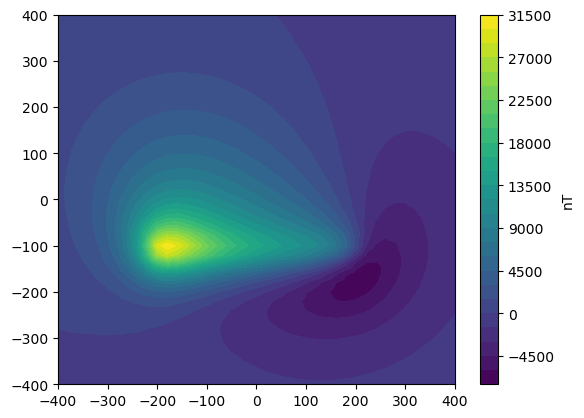

In [16]:
simulation = mag.simulation.Simulation3DDifferential(
    survey=survey,
    mesh = mesh,
    muMap=mu_map,
    remMap=rem_map,
)

#Compute the data for our model

d_pred = simulation.dpred(model)

#Plot up the data

im=plt.tricontourf(rx_points[:,0],rx_points[:,1],d_pred,levels=30)
plt.colorbar(label='nT')


We can also plot up the total magnetization, or to a scaling factor magnetic polarization $\mu_0 \mathbf{M}$.

In finite volume, this computed quantity is computed on cell faces, so we average back to cell centers to plot

We can compare this to the approximate solution, where the effective susceptibility is $(3,3,-5) (SI)$

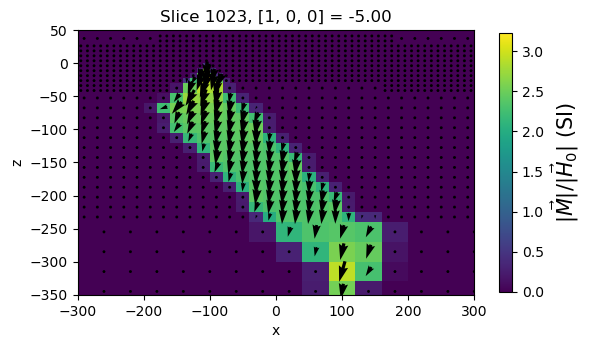

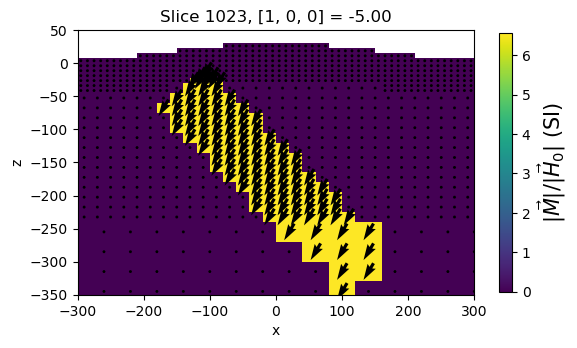

In [17]:
mu0_M=simulation.magnetic_polarization(model)

chi_eff = mu0_M/survey.source_field.amplitude

chi_eff = mesh.average_face_to_cell_vector*chi_eff

mu0_M_plot = mesh.average_face_to_cell_vector*mu0_M

im=mesh.plot_slice((chi_eff).reshape((-1,3),order='F'), normal="x",slice_loc=0, grid=False,view="vec",v_type="CCv",quiver_opts={
                "pivot": "mid",
                "scale": 10,
                "width":.008,
                "scale_units": "inches",
            },)

plt.gca().set_aspect("equal")
cbar=plt.colorbar(im[0][0],shrink=.7)
cbar.set_label(r'$|\vec{M}|/|\vec{H}_0|$ (SI)',rotation=90,size=15)
plt.xlim(-300, 300)
plt.ylim(-350, 50)
plt.show()

m_x = np.zeros(n_active)
m_x[ind_prism] = 3
m_y = np.zeros(n_active)
m_y[ind_prism] = -3
m_z = np.zeros(n_active)
m_z[ind_prism] = -5

im=mesh.plot_slice(plot_map*np.c_[m_x,m_y,m_z], normal="x",slice_loc=-0, grid=False,view="vec",v_type="CCv",quiver_opts={
                "pivot": "mid",
                "scale": 30,
                "width":.008,
                "scale_units": "inches",
            },)

plt.gca().set_aspect("equal")
cbar=plt.colorbar(im[0][0],shrink=.7)
cbar.set_label(r'$|\vec{M}|/|\vec{H}_0|$ (SI)',rotation=90,size=15)
plt.xlim(-300, 300)
plt.ylim(-350, 50)
plt.show()







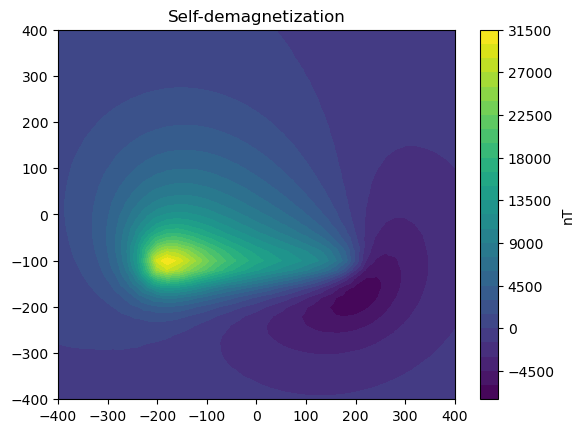

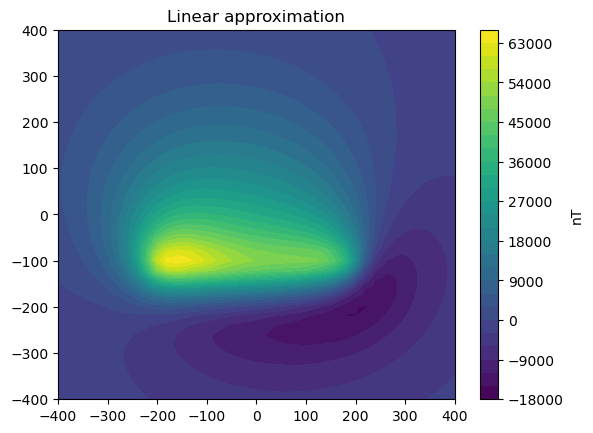

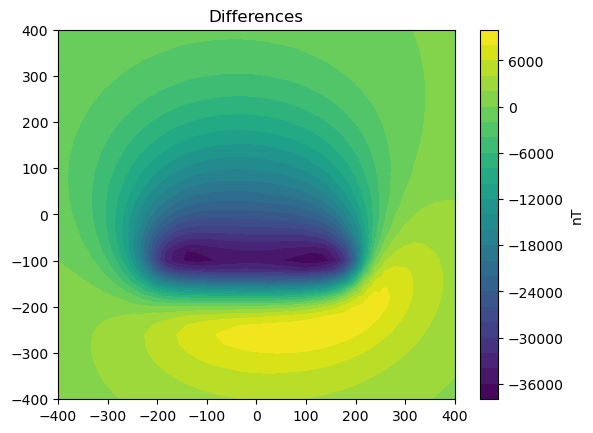

In [18]:
#plot difference in data
linear_magnetization_model =np.r_[np.zeros(n_active),m_x,m_y,m_z]

dpred_linear = simulation.dpred(linear_magnetization_model)

im=plt.tricontourf(rx_points[:,0],rx_points[:,1],d_pred,levels=30)
plt.title('Self-demagnetization')
plt.colorbar(label='nT')
plt.show()

im=plt.tricontourf(rx_points[:,0],rx_points[:,1],dpred_linear,levels=30)
plt.title('Linear approximation')
plt.colorbar(label='nT')
plt.show()

im=plt.tricontourf(rx_points[:,0],rx_points[:,1],d_pred-dpred_linear,levels=30)
plt.title('Differences')
plt.colorbar(label='nT')
plt.show()


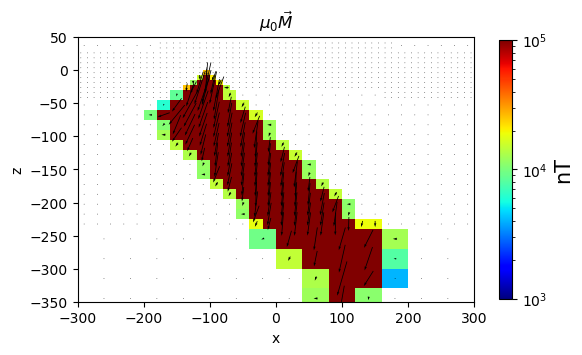

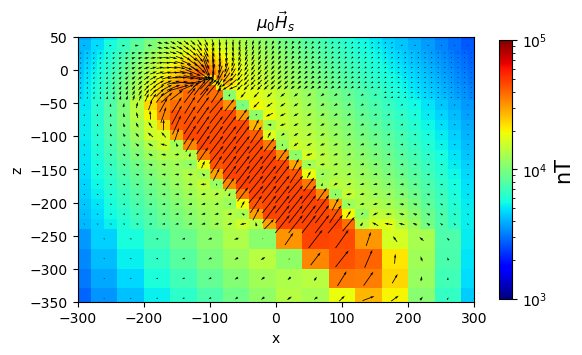

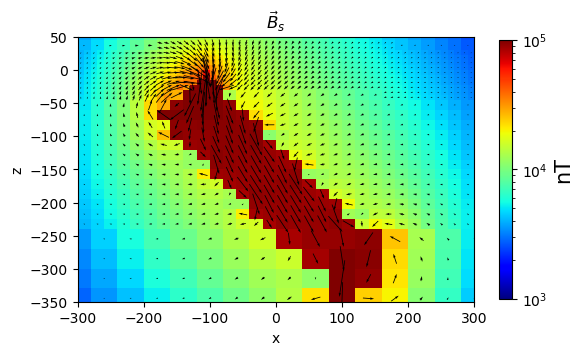

In [19]:
#Plot up the fields

from matplotlib import colors


im=mesh.plot_slice((mu0_M_plot).reshape((-1,3),order='F'), normal="x",slice_loc=0, grid=False,view="vec",v_type="CCv",
                pcolorOpts={'cmap':'jet','norm': colors.LogNorm(vmin=1e3, vmax=1e5)},
                quiver_opts={
                "pivot": "mid",
                "scale": 300000,
                "width":.002,
                "scale_units": "inches",
            },)

plt.title(r'$\mu_0\vec{M}$')
plt.gca().set_aspect("equal")
cbar=plt.colorbar(im[0][0],shrink=.7)
cbar.set_label(r'nT',rotation=90,size=15)
plt.xlim(-300, 300)
plt.ylim(-350, 50)
plt.show()

bfield = mesh.average_face_to_cell_vector*simulation.fields(model)["b"]

im=mesh.plot_slice((bfield-mu0_M_plot).reshape((-1,3),order='F'), normal="x",slice_loc=0, grid=False,view="vec",v_type="CCv",
                pcolorOpts={'cmap':'jet','norm': colors.LogNorm(vmin=1e3, vmax=1e5)},
                quiver_opts={
                "pivot": "mid",
                "scale": 200000,
                "width":.002,
                "scale_units": "inches",
            },)

plt.title(r'$\mu_0\vec{H}_s$')
plt.gca().set_aspect("equal")
cbar=plt.colorbar(im[0][0],shrink=.7)
cbar.set_label(r'nT',rotation=90,size=15)
plt.xlim(-300, 300)
plt.ylim(-350, 50)
plt.show()




im=mesh.plot_slice((bfield).reshape((-1,3),order='F'), normal="x",slice_loc=0, grid=False,view="vec",v_type="CCv",
                pcolorOpts={'cmap':'jet','norm': colors.LogNorm(vmin=1e3, vmax=1e5)},
                quiver_opts={
                "pivot": "mid",
                "scale": 200000,
                "width":.002,
                "scale_units": "inches",
            },)


plt.title(r'$\vec{B}_s$')
plt.gca().set_aspect("equal")
cbar=plt.colorbar(im[0][0],shrink=.7)
cbar.set_label(r'nT',rotation=90,size=15)
plt.xlim(-300, 300)
plt.ylim(-350, 50)
plt.show()